# Predicting NO2 Concentration in Air
### Dataset
Air Quality Dataset from UC Irvine Machine Learning Repository

Link: https://archive.ics.uci.edu/dataset/360/air+quality

This time-series dataset comprises hourly records from five metal oxide chemical sensors monitoring air quality in an Italian city over one year (March 2004 to February 2005). It captures hourly average concentrations of CO, hydrocarbons, benzene, NOx, and NO2(Nitrogen Dioxide). Given Nitrogen Dioxide's impact on human health, our primary focus is on tracking its concentration. In this notebook, we will train, test and evaluate XGBoost model to predict NO2 levels.

### 1. Import Libraries

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Utilities import create_sequences, train_and_save_model, load_and_test_model

### 2. Load Data

In [2]:
df = pd.read_excel('../../Data/Updated_AirQualityUCI.xlsx')

In [3]:
df.shape

(9357, 20)

In [4]:
df.head()

,DateTime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),log_C6H6(GT),sqrt_C6H6(GT),PT08.S2(NMHC),log_PT08.S2(NMHC),sqrt_PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),log_PT08.S4(NO2),sqrt_PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,0.211864,0.511849,0.120981,0.184498,0.169319,0.429532,0.361737,0.308761,0.601446,0.111036,0.311024,0.328694,0.513040,0.414121,0.716268,0.454654,0.333333,0.499057,0.280046
1,2004-03-10 19:00:00,0.161017,0.463196,0.120981,0.145428,0.135778,0.381350,0.312167,0.271680,0.558719,0.068382,0.360796,0.266509,0.453125,0.373716,0.673146,0.326382,0.326882,0.484287,0.264279
2,2004-03-10 20:00:00,0.177966,0.542011,0.120981,0.139148,0.130281,0.373026,0.303701,0.265207,0.551090,0.087339,0.346500,0.331655,0.451214,0.372400,0.671725,0.370588,0.296774,0.563168,0.276374
3,2004-03-10 21:00:00,0.177966,0.522980,0.120981,0.142780,0.133464,0.377863,0.308617,0.268971,0.555533,0.115098,0.326168,0.355345,0.464366,0.381422,0.681444,0.426741,0.277419,0.638906,0.294198
4,2004-03-10 22:00:00,0.127119,0.448833,0.120981,0.100156,0.095452,0.316475,0.247030,0.220765,0.497021,0.087339,0.374034,0.337578,0.422212,0.352214,0.649779,0.386228,0.280645,0.633564,0.295215


In [5]:
df.dtypes

DateTime              datetime64[ns]
CO(GT)                       float64
PT08.S1(CO)                  float64
NMHC(GT)                     float64
C6H6(GT)                     float64
log_C6H6(GT)                 float64
sqrt_C6H6(GT)                float64
PT08.S2(NMHC)                float64
log_PT08.S2(NMHC)            float64
sqrt_PT08.S2(NMHC)           float64
NOx(GT)                      float64
PT08.S3(NOx)                 float64
NO2(GT)                      float64
PT08.S4(NO2)                 float64
log_PT08.S4(NO2)             float64
sqrt_PT08.S4(NO2)            float64
PT08.S5(O3)                  float64
T                            float64
RH                           float64
AH                           float64
dtype: object

The data types for all numeric values are correct. 

Also, top 2 correlated variables PT08.S2(NMHC) and C6H6(GT) are normalized and tranformed for modelling. So, we will train, test and evaluate VAR which is a multivariate model in this notebook.

##### Data:

CO(GT), NMHC(GT), C6H6(GT), NOx(GT) and NO2(GT) are ground truth values of these gases in air.

PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2) and PT08.S5(O3) are sensored responses values.

T is Temperature of the air

RH is Relative Humidity in the air

AH is Absolute Humidity in the air

Our main focus is to predict NO2 gas concentation according to sesored responses in air, i.e. PT08.S4(NO2)

### 3. Model
#### 3.1. Preparing data

In [6]:
df_model = df[['PT08.S4(NO2)', 'PT08.S2(NMHC)', 'C6H6(GT)']].dropna()

# Train-test split (80-20 split)
train_size = int(len(df_model) * 0.8)
train_data, test_data = df_model.iloc[:train_size], df_model.iloc[train_size:]

train_data.to_csv("../../Data/xgboost_train_data.csv", index=True)
test_data.to_csv("../../Data/xgboost_test_data.csv", index=True)

target_column = "PT08.S4(NO2)"
seq_length = 5

#### 3.2. Training XGBoost model

In [7]:
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

xgb_model = train_and_save_model(X_train, y_train, model_path="xgboost_model.pkl")

Model trained and saved at xgboost_model.pkl


#### 3.3. Testing and Evaluation XGBoost model

In [8]:
predictions, metrics = load_and_test_model(X_test, y_test, model_path="xgboost_model.pkl")

RMSE: 0.05406104600942621
MAE: 0.0352139565673682


#### 3.4 Plotting

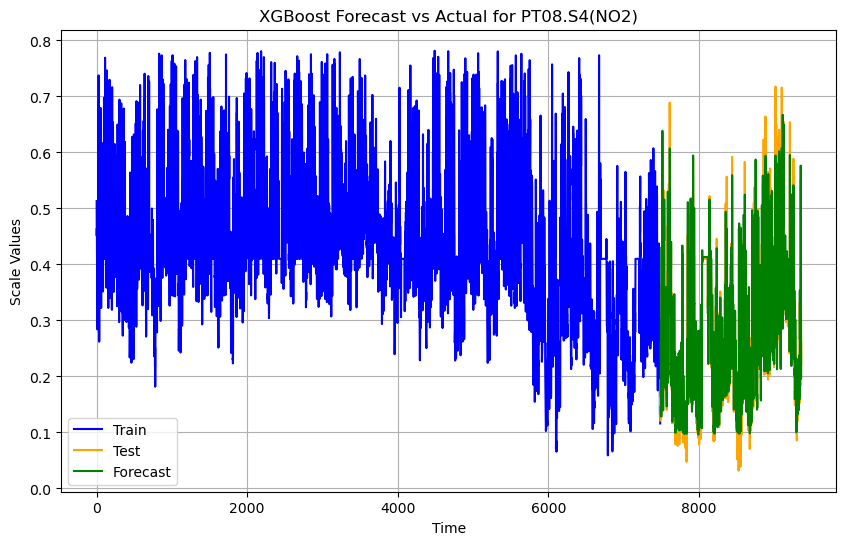

In [9]:
predictions_df = pd.DataFrame(predictions, index=test_data.index[seq_length:], columns=['Forecast'])
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['PT08.S4(NO2)'], label='Train', color='blue')
plt.plot(test_data.index, test_data['PT08.S4(NO2)'], label='Test', color='orange')
plt.plot(predictions_df.index, predictions_df['Forecast'], label='Forecast', color='green')
plt.legend()
plt.title('XGBoost Forecast vs Actual for PT08.S4(NO2)')
plt.xlabel('Time')
plt.ylabel('Scale Values')
plt.grid()
plt.show()

Considering the RMSE and MAE evaluation metrics, the model is good fit to the actual data, showing strong predictive accuracy.